## Final Project Submission

Please fill out:
* Student name: Emmanuel Kiplimo
* Student pace: Full Time
* Scheduled project review date/time: 3/10/2022
* Instructor name: William Okomba



## Overview

A real estate agency in King County, Washington State is looking to explore sales and details on houses in the region to identify various features and factors that significantly contribute to the price of houses. As a Data Scientist, I'll analyze and model the data provided to draw insights and predictions on house prices. 

The following queries will shed some light on house sales and features of an ideal house and a serve as build up for a predictive model:

1. Notable features that contribute to house prices.
2. Is there an observable trend of house sales across the year

### Data understanding

In [242]:
# Import standard packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [243]:
# Loading data onto a dataframe
df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

From the above summary: 
* The data set has 21597 entries
* object type columns have to be explored further 
    * date       
    * waterfront 
    * view  
    * condition
    * grade
    * sqft_basement
 

## Data preparation

In [245]:
df['date']

0        10/13/2014
1         12/9/2014
2         2/25/2015
3         12/9/2014
4         2/18/2015
            ...    
21592     5/21/2014
21593     2/23/2015
21594     6/23/2014
21595     1/16/2015
21596    10/15/2014
Name: date, Length: 21597, dtype: object

In [246]:
# Change date column from object to the appropriate data type (datetime)
# We may later need to re-engineer the date column to derive seasons
df['date'] = pd.to_datetime(df['date'])

In [247]:
print(df['waterfront'].unique())
df['waterfront'].describe()

[nan 'NO' 'YES']


count     19221
unique        2
top          NO
freq      19075
Name: waterfront, dtype: object

Waterfront column seems to be a binary column. Having 1 and 0 to represent 'YES' and 'NO' respectively will make analysis much simpler. It's also safe to replace the missing values with the mode; The house not having a view of the waterfront

In [248]:
def waterfront(df):
    df['waterfront'] = df['waterfront'].map(lambda x: 1 if x == 'YES' else 0)
    return df

df = waterfront(df)
df['waterfront'].unique()

array([0, 1])

In [249]:
print(df['view'].unique())

['NONE' nan 'GOOD' 'EXCELLENT' 'AVERAGE' 'FAIR']


In [250]:
# The null values could be filled with 'NONE'
print(df['view'].isna().value_counts())


False    21534
True        63
Name: view, dtype: int64


In [251]:
print(df['view'].value_counts())

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64


Using a quantitative variable to represent quality of view from the house would be more effective in EDA

In [252]:
#Function to handle null values and change the view column into int based column
def view(df):
    df['view'].fillna(1,inplace = True)
    old = ['NONE','AVERAGE','FAIR','GOOD','EXCELLENT']
    new = [1,2,3,4,5]

    df['view'].replace(old,new,inplace=True)
    return df
    
df = view(df)
df['view'].unique()

array([1, 4, 5, 2, 3])

In [253]:
df['grade'].unique()

array(['7 Average', '6 Low Average', '8 Good', '11 Excellent', '9 Better',
       '5 Fair', '10 Very Good', '12 Luxury', '4 Low', '3 Poor',
       '13 Mansion'], dtype=object)

In [254]:
def grade(df):
    old = ['3 Poor','4 Low','5 Fair','6 Low Average','7 Average','8 Good','9 Better','10 Very Good','11 Excellent','12 Luxury','13 Mansion']
    new = [3,4,5,6,7,8,9,10,11,12,13]
    
    df['grade'].replace(old,new,inplace=True)
    return df
df = grade(df)
df['grade'].unique()

array([ 7,  6,  8, 11,  9,  5, 10, 12,  4,  3, 13])

In [255]:
df['bathrooms'].unique()

array([1.  , 2.25, 3.  , 2.  , 4.5 , 1.5 , 2.5 , 1.75, 2.75, 3.25, 4.  ,
       3.5 , 0.75, 4.75, 5.  , 4.25, 3.75, 1.25, 5.25, 6.  , 0.5 , 5.5 ,
       6.75, 5.75, 8.  , 7.5 , 7.75, 6.25, 6.5 ])

* The floating point values in the bathroom column could be indicating the amenities in the bathroom. A whole number could be representing a bathroom with all features, i.e `shower`, `toilet` and a `sink`
* Working with integer values would be more suitable.

In [256]:
# A function to have bathroom columns as int
def bathrooms(df):
    df['bathrooms'] = df['bathrooms'].map(lambda x: int(round(x,0)))
    return df
df = bathrooms(df)
df['bathrooms'].unique()

array([1, 2, 3, 4, 5, 6, 0, 7, 8])

In [257]:
df['sqft_basement'].unique()

array(['0.0', '400.0', '910.0', '1530.0', '?', '730.0', '1700.0', '300.0',
       '970.0', '760.0', '720.0', '700.0', '820.0', '780.0', '790.0',
       '330.0', '1620.0', '360.0', '588.0', '1510.0', '410.0', '990.0',
       '600.0', '560.0', '550.0', '1000.0', '1600.0', '500.0', '1040.0',
       '880.0', '1010.0', '240.0', '265.0', '290.0', '800.0', '540.0',
       '710.0', '840.0', '380.0', '770.0', '480.0', '570.0', '1490.0',
       '620.0', '1250.0', '1270.0', '120.0', '650.0', '180.0', '1130.0',
       '450.0', '1640.0', '1460.0', '1020.0', '1030.0', '750.0', '640.0',
       '1070.0', '490.0', '1310.0', '630.0', '2000.0', '390.0', '430.0',
       '850.0', '210.0', '1430.0', '1950.0', '440.0', '220.0', '1160.0',
       '860.0', '580.0', '2060.0', '1820.0', '1180.0', '200.0', '1150.0',
       '1200.0', '680.0', '530.0', '1450.0', '1170.0', '1080.0', '960.0',
       '280.0', '870.0', '1100.0', '460.0', '1400.0', '660.0', '1220.0',
       '900.0', '420.0', '1580.0', '1380.0', '475.0', 

In [258]:
df['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
1920.0        1
3480.0        1
2730.0        1
2720.0        1
248.0         1
Name: sqft_basement, Length: 304, dtype: int64

In [259]:
df['sqft_basement'].describe()

count     21597
unique      304
top         0.0
freq      12826
Name: sqft_basement, dtype: object

* From the summary statistics it seems many houses don't have a basement hence 0 sqft. The '?' is a place holder for 454 houses in which the basement status is not indicated
* Having the basement status as a binary option could provide better insights as compared to the size.

In [260]:
def basement(df):
    df['sqft_basement'] = df['sqft_basement'].map(lambda x : float(x.replace('?', '0')))
    df['basement'] = df['sqft_basement'].map(lambda x: 1 if x > 0 else 0)
    df['sqft_basement'] = df['basement']
    
    return df

df = basement(df)
df['basement'].unique()


array([0, 1])

In [261]:
# Let's check for duplicates and remove them if any
df[df.duplicated()==True].shape


(0, 22)

In [262]:
# Determinig missing values
df.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
basement            0
dtype: int64

* There seems to be no duplicated rows across the 22 colums
* Most of the null values were handled in the initial feature engineering apart from `yr_renovated`

In [263]:
df['yr_renovated'].dropna(inplace=True)

### Data Analysis

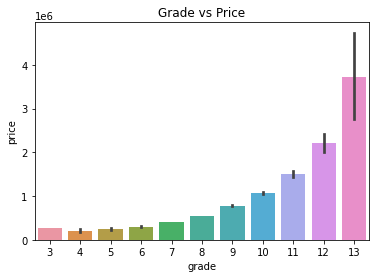

In [264]:
sns.barplot(x='grade',y='price',data=df)
plt.title("Grade vs Price")
plt.show()

* The grade of the house refers to the general quality of the house with 3 being poor quality and 13 being more than luxurious.
* Renovations are likely to improve the grade and genreal condition of the house hence contributing to the overall price.

In [265]:
df['bedrooms'].value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [266]:
df[df['bedrooms'] > 10 ]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement
8748,1773100755,2014-08-21,520000.0,11,3,3000,4960,2.0,0,1,...,2400,1,1918,1999.0,98106,47.5560,-122.363,1420,4960,1
15856,2402100895,2014-06-25,640000.0,33,2,1620,6000,1.0,0,1,...,1040,1,1947,0.0,98103,47.6878,-122.331,1330,4700,1


The two houses with 11 and 33 bedrooms have a significantly lower ratio of bathrooms. It's highly likely to be an anomaly  and should therefore be dropped. 

In [267]:
outliers = df[df['bedrooms'] > 10 ].index
df.drop(outliers, inplace=True)

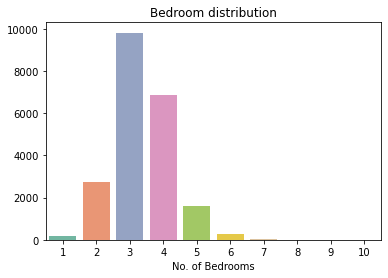

In [268]:
# Bedroom distribution
counts = df["bedrooms"].value_counts()
sns.barplot(x=counts.index,y=counts.values,palette=("Set2"))
plt.xlabel("No. of Bedrooms")
plt.title("Bedroom distribution")
plt.show()


A typical household has 3 bedrooms followed by 4 bedroom and 3 bedroom houses. 

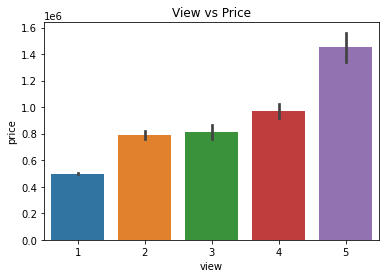

In [269]:
sns.barplot(x='view',y='price',data=df)
plt.title('View vs Price');

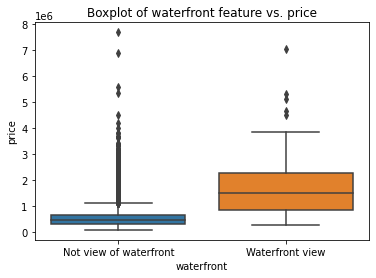

In [270]:
sns.boxplot(x = df['waterfront'], y = df['price'])
plt.xticks(np.arange(2), ('Not view of waterfront', 'Waterfront view'))
plt.title("Boxplot of waterfront feature vs. price")
plt.show()

In [271]:
waterfront = df[df['waterfront'] == 1]['price'].mean()
non_waterfront = df[df['waterfront'] == 0]['price'].mean()
print(f"A house with a waterfront has an average price of USD {round(waterfront,2)}")
print(f"Houses without a waterfront have an average price of USD {round(non_waterfront,2)}")

A house with a waterfront has an average price of USD 1717214.73
Houses without a waterfront have an average price of USD 532281.77


In [272]:
df['sale_year'] = df.apply(lambda x: x.date.year, axis=1)
df['sale_year'].value_counts()

2014    14620
2015     6975
Name: sale_year, dtype: int64

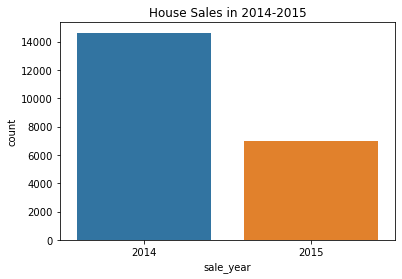

In [273]:
sns.countplot(x = df['sale_year'])
plt.title('House Sales in 2014-2015')
plt.show()


In [274]:
# A function to determine season from the date column
def monthToSeason(df):
    df['sale_month'] = df.apply(lambda x: x.date.month, axis=1)
    seasons={1:'Winter',2:'Winter',3:'Spring',4:'Spring',5:'Spring',6:'Summer',
                 7:'Summer',8:'Summer',9:'Fall',10:'Fall',11:'Fall',12:'Winter'}
    df['season']=df.sale_month.map(seasons)
    return df

df = monthToSeason(df)
df['season'].unique()

array(['Fall', 'Winter', 'Spring', 'Summer'], dtype=object)

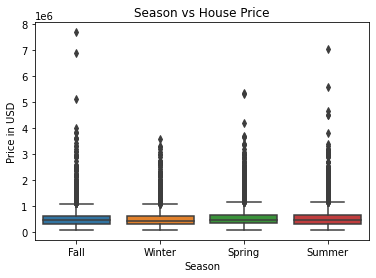

In [275]:
sns.boxplot(x = df['season'], y = df['price'], data = df)
plt.xlabel('Season')
plt.ylabel('Price in USD')
plt.title('Season vs House Price')
plt.show()

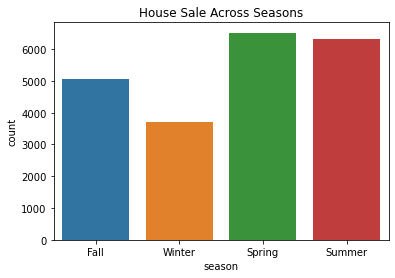

In [276]:
sns.countplot(x=df['season'])
plt.title('House Sale Across Seasons')
plt.show()

* There's an interesting observation in house sales across the years, almost twice as many houses were sold in 2014 as compared to 2015.
* The season has little to no impact on the overall price of the house.
* Many houses are sold/bought in Spring and Summer.
* Gearing our market campaings during Fall and Winter could get the ball rolling and complete purchase/sale in Spring and Winter

### Modelling 

In [277]:
df.sort_values("price", ascending = False).head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement,sale_year,sale_month,season
7245,6762700020,2014-10-13,7700000.0,6,8,12050,27600,2.5,0,4,...,1987.0,98102,47.6298,-122.323,3940,8800,1,2014,10,Fall
3910,9808700762,2014-06-11,7060000.0,5,4,10040,37325,2.0,1,2,...,2001.0,98004,47.6500,-122.214,3930,25449,1,2014,6,Summer
9245,9208900037,2014-09-19,6890000.0,6,8,9890,31374,2.0,0,5,...,0.0,98039,47.6305,-122.240,4540,42730,1,2014,9,Fall
4407,2470100110,2014-08-04,5570000.0,5,6,9200,35069,2.0,0,1,...,NaN,98039,47.6289,-122.233,3560,24345,1,2014,8,Summer
1446,8907500070,2015-04-13,5350000.0,5,5,8000,23985,2.0,0,5,...,0.0,98004,47.6232,-122.220,4600,21750,1,2015,4,Spring


In [278]:
#Explore the relationshp between price and other columns
df.corr('pearson')['price']

id              -0.016765
price            1.000000
bedrooms         0.316504
bathrooms        0.519652
sqft_living      0.701948
sqft_lot         0.089879
floors           0.256828
waterfront       0.264308
view             0.394713
grade            0.667967
sqft_above       0.605401
sqft_basement    0.178264
yr_built         0.053964
yr_renovated     0.129702
zipcode         -0.053408
lat              0.306687
long             0.022045
sqft_living15    0.585274
sqft_lot15       0.082848
basement         0.178264
sale_year        0.003734
sale_month      -0.009925
Name: price, dtype: float64

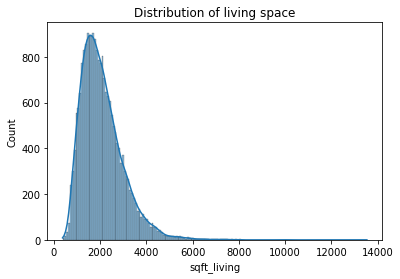

In [279]:
# living space Distribution
sns.histplot(df['sqft_living'], kde=True);
plt.title("Distribution of living space")
plt.show()

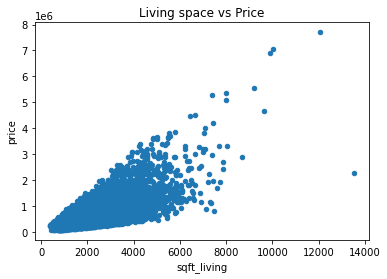

In [280]:
# The 'sqft_living' column has the highest relationship with price
df.plot(x='sqft_living',y='price', kind='scatter')
plt.title("Living space vs Price")
plt.show()

* From the two distributions, most of the houses have a living space within 6000 sqft and tend to cost a figure below $4,000,000

In [281]:
train_data,test_data=train_test_split(df,train_size=0.8,random_state=3)
reg=LinearRegression()
x_train=np.array(train_data['sqft_living']).reshape(-1,1)
y_train=np.array(train_data['price']).reshape(-1,1)
reg.fit(x_train,y_train)

x_test=np.array(test_data['sqft_living']).reshape(-1,1)
y_test=np.array(test_data['price']).reshape(-1,1)
pred=reg.predict(x_test)

Sqaured mean error 273789.66
R squared training 0.494
R sqaured testing 0.488
intercept [-38017.20149875]
coefficient [[277.90934404]]


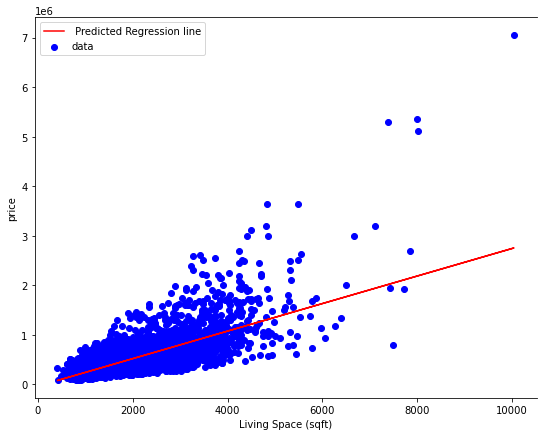

In [282]:
plt.subplots(figsize = (9, 7))
plt.scatter(x_test, y_test, color= 'blue', label = 'data')
plt.plot(x_test, reg.predict(x_test), color ='red', label = ' Predicted Regression line')
plt.xlabel('Living Space (sqft)')
plt.ylabel('price')
plt.legend()
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

#Model summary
mean_squared_error=metrics.mean_squared_error(y_test,pred)
print('Sqaured mean error', round(np.sqrt(mean_squared_error),2))
print('R squared training',round(reg.score(x_train,y_train),3))
print('R sqaured testing',round(reg.score(x_test,y_test),3) )
print('intercept',reg.intercept_)
print('coefficient',reg.coef_)

* After living space, grade of the house is the next variable to have a strong correlation with price.

In [283]:
train_data,test_data = train_test_split(df,train_size=0.8,random_state=3)
reg = LinearRegression()
x_train = np.array(train_data['grade']).reshape(-1,1)
y_train = np.array(train_data['price']).reshape(-1,1)
reg.fit(x_train,y_train)

x_test = np.array(test_data['grade']).reshape(-1,1)
y_test = np.array(test_data['price']).reshape(-1,1)
pred = reg.predict(x_test)

print("Model 1")
mean_squared_error=metrics.mean_squared_error(y_test,pred)
print('squared mean error',round(np.sqrt(mean_squared_error),2))
print('R squared training',round(reg.score(x_train,y_train),3))
print('R squared testing',round(reg.score(x_test,y_test),3))
print('intercept',reg.intercept_)
print('coeeficient',reg.coef_)



Model 1
squared mean error 288645.26
R squared training 0.45
R squared testing 0.431
intercept [-1050417.80366832]
coeeficient [[207678.58717913]]


### Multiple regression

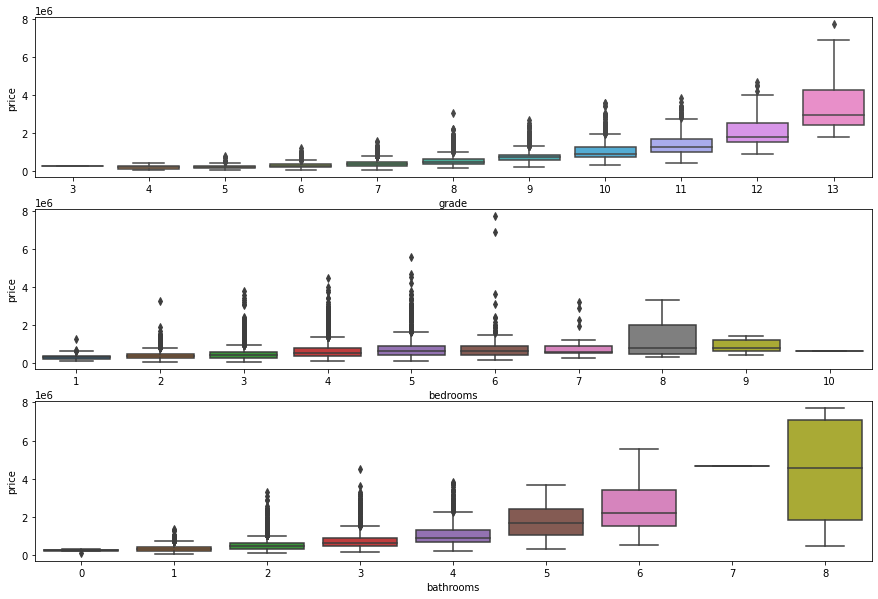

In [284]:
fig,ax=plt.subplots(3,1,figsize=(15,10))
sns.boxplot(x=train_data['grade'],y=train_data['price'],ax=ax[0])
sns.boxplot(x=train_data['bedrooms'],y=train_data['price'],ax=ax[1])
sns.boxplot(x=train_data['bathrooms'],y=train_data['price'],ax=ax[2])
plt.show()

In [285]:
model_2 = ['bedrooms','grade','sqft_living','sqft_above']
reg=LinearRegression()
reg.fit(train_data[model_2],train_data['price'])
pred=reg.predict(test_data[model_2])
print('Model 2')
mean_squared_error=metrics.mean_squared_error(y_test,pred)
print('mean squared error(MSE)', round(np.sqrt(mean_squared_error),2))
print('R squared training',round(reg.score(train_data[model_2],train_data['price']),3))
print('R squared testing', round(reg.score(test_data[model_2],test_data['price']),3))
print('Intercept: ', reg.intercept_)
print('Coefficient:', reg.coef_)

Model 2
mean squared error(MSE) 260437.56
R squared training 0.554
R squared testing 0.537
Intercept:  -513600.3368259696
Coefficient: [-4.73070108e+04  1.04713234e+05  2.68444581e+02 -8.22739427e+01]


In [286]:
model_3 = ['basement','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','grade','sqft_above','lat']
reg = LinearRegression()
reg.fit(train_data[model_3],train_data['price'])
pred = reg.predict(test_data[model_3])

print('Model 3')
mean_squared_error = metrics.mean_squared_error(y_test, pred)
print('Mean Squared Error (MSE) ', round(np.sqrt(mean_squared_error), 2))
print('R-squared (training) ', round(reg.score(train_data[model_3], train_data['price']), 3))
print('R-squared (testing) ', round(reg.score(test_data[model_3], test_data['price']), 3))
print('Intercept: ', reg.intercept_)
print('Coefficient:', reg.coef_)

Model 3
Mean Squared Error (MSE)  222830.8
R-squared (training)  0.659
R-squared (testing)  0.661
Intercept:  -31881653.514645867
Coefficient: [ 2.13948976e+03 -3.24404951e+04  2.20573040e+04  1.77897381e+02
 -1.94735194e-01 -3.82042849e+04  5.25017963e+05  7.83235763e+04
  8.10187710e+04  1.27264594e+01  6.60923385e+05]


### Model summary 

* Our third model better as compared to our baseline model.
* It was a better predictor of price as it had a lower error value and a higher R-Squared value

### Conclusions
* An increase in the number of `bedrooms` and `bathrooms` increases the price of the house. Houses with a good view also tend to fetch high prices

* Grade is a good indicator of price. Renovations will therefore contribute to price as it improves the house condition and grade to some extent.

* Houses with a waterfront cost thrice as smuch as houses without. This are high end properties that should have customised marketing campaign.

* The season or time of the year was a prospect in determining price but it turns out there's no significant contribution. However, the distribution gives some insight on timing of our marketing campaigns.